In [15]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import joblib
import json
from datetime import datetime
warnings.filterwarnings('ignore')

In [16]:
# Cell 2: Configuration
REGIONS = ['delhi', 'kolkata']
MEDICINES = {
    'delhi': ['paracetamol', 'ibuprofen', 'amoxicillin', 'cetirizine', 'salbutamol'],
    'kolkata': ['paracetamol', 'ibuprofen', 'amoxicillin', 'loperamide', 'metronidazole']
}

FESTIVAL_DATES = {
    'delhi': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-08-03', '2021-08-22', '2022-08-11', '2023-08-30'   # Raksha Bandhan
    ],
    'kolkata': [
        '2020-10-25', '2021-11-04', '2022-10-24', '2023-11-12',  # Diwali
        '2020-10-22', '2021-10-15', '2022-10-05', '2023-10-24'   # Durga Puja
    ]
}

In [17]:
# Cell 3: Data Loading Functions
def load_data(region: str, medicine: str) -> pd.DataFrame:
    """Load and prepare data for Prophet"""
    file_path = Path(f"../../dataset/data/{region}/processed/{medicine}_prophet.csv")
    df = pd.read_csv(file_path)
    df['ds'] = pd.to_datetime(df['ds'])
    return df

def create_events_df(start_date: pd.Timestamp, end_date: pd.Timestamp, region: str) -> pd.DataFrame:
    """Create events dataframe with festival dates"""
    date_range = pd.date_range(start=start_date, end=end_date + pd.Timedelta(days=90))
    events_df = pd.DataFrame({'ds': date_range})
    events_df['special_event'] = 0
    
    # Mark festival dates
    festival_dates = pd.to_datetime(FESTIVAL_DATES[region])
    events_df.loc[events_df['ds'].isin(festival_dates), 'special_event'] = 1
    
    return events_df

In [18]:
# Cell 4: Model Training and Tuning Functions
def tune_prophet_hyperparameters(df: pd.DataFrame, events_df: pd.DataFrame = None) -> tuple:
    """Tune Prophet hyperparameters using grid search"""
    param_grid = {
        'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['multiplicative', 'additive']
    }
    
    best_params = {}
    best_rmse = float('inf')
    
    for cp in param_grid['changepoint_prior_scale']:
        for sp in param_grid['seasonality_prior_scale']:
            for sm in param_grid['seasonality_mode']:
                params = {
                    'changepoint_prior_scale': cp,
                    'seasonality_prior_scale': sp,
                    'seasonality_mode': sm,
                    'yearly_seasonality': True,
                    'weekly_seasonality': True,
                    'daily_seasonality': False
                }
                
                model = Prophet(**params)
                
                if events_df is not None:
                    df_with_events = df.merge(events_df, on='ds', how='left')
                    df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
                    model.add_regressor('special_event', mode='multiplicative')
                    model.fit(df_with_events)
                else:
                    model.fit(df)
                
                # Cross validation
                df_cv = cross_validation(model, initial='365 days', period='90 days', horizon='90 days')
                df_p = performance_metrics(df_cv)
                rmse = df_p['rmse'].mean()
                
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = params
                
                print(f"Parameters: {params}")
                print(f"RMSE: {rmse:.2f}")
                print("---")
    
    return best_params, best_rmse

def train_model(df: pd.DataFrame, params: dict, events_df: pd.DataFrame = None) -> Prophet:
    """Train Prophet model with given parameters"""
    model = Prophet(**params)
    
    if events_df is not None:
        df_with_events = df.merge(events_df, on='ds', how='left')
        df_with_events['special_event'] = df_with_events['special_event'].fillna(0)
        model.add_regressor('special_event', mode='multiplicative')
        model.fit(df_with_events)
    else:
        model.fit(df)
    
    return model

In [19]:
# Cell 5: Evaluation Functions
def evaluate_model(y_true: np.array, y_pred: np.array) -> dict:
    """Calculate model evaluation metrics"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_true - y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }

In [20]:
# Cell 6: Visualization Functions
def plot_forecast(model: Prophet, forecast: pd.DataFrame, title: str):
    """Plot forecast with components"""
    fig = model.plot(forecast)
    plt.title(f'{title} - Forecast')
    plt.show()
    
    fig = model.plot_components(forecast)
    plt.suptitle(f'{title} - Components')
    plt.tight_layout()
    plt.show()


In [21]:
# Cell 7: Main Training Loop - Start with Paracetamol
def train_single_medicine(region: str, medicine: str, include_events: bool = True) -> dict:
    """Train and evaluate model for a single medicine in a region"""
    print(f"\nTraining model for {medicine} in {region}")
    
    # Load data
    df = load_data(region, medicine)
    
    # Create events dataframe if needed
    events_df = None
    if include_events:
        events_df = create_events_df(df['ds'].min(), df['ds'].max(), region)
    
    # Tune hyperparameters
    print("\nTuning hyperparameters...")
    best_params, best_rmse = tune_prophet_hyperparameters(df, events_df)
    print(f"\nBest parameters: {best_params}")
    print(f"Best RMSE: {best_rmse:.2f}")
    
    # Train final model
    print("\nTraining final model...")
    model = train_model(df, best_params, events_df)
    
    # Generate forecast
    future = model.make_future_dataframe(periods=90)
    if events_df is not None:
        future = future.merge(events_df, on='ds', how='left')
        future['special_event'] = future['special_event'].fillna(0)
    
    forecast = model.predict(future)
    
    # Evaluate model
    metrics = evaluate_model(
        df['y'].values,
        forecast['yhat'][:len(df)]
    )
    
    # Plot results
    plot_forecast(model, forecast, f"{region.title()} - {medicine.title()}")
    
    return {
        'model': model,
        'forecast': forecast,
        'metrics': metrics,
        'params': best_params
    }


05:19:20 - cmdstanpy - INFO - Chain [1] start processing
05:19:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for paracetamol in delhi

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:20 - cmdstanpy - INFO - Chain [1] start processing
05:19:20 - cmdstanpy - INFO - Chain [1] done processing
05:19:20 - cmdstanpy - INFO - Chain [1] start processing
05:19:20 - cmdstanpy - INFO - Chain [1] done processing
05:19:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:20 - cmdstanpy - INFO - Chain [1] start processing
05:19:21 - cmdstanpy - INFO - Chain [1] done processing
05:19:21 - cmdstanpy - INFO - Chain [1] start processing
05:19:21 - cmdstanpy - INFO - Chain [1] done processing
05:19:21 - cmdstanpy - INFO - Chain [1] start processing
05:19:21 - cmdstanpy - INFO - Chain [1] done processing
05:19:21 - cmdstanpy - INFO - Chain [1] start processing
05:19:21 - cmdstanpy - INFO - Chain [1] done processing
05:19:21 - cmdstanpy - INFO - Chain [1] start processing
05:19:21 - cmdstanpy - INFO - Chain [1] done processing
05:19:22 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.66
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:23 - cmdstanpy - INFO - Chain [1] start processing
05:19:23 - cmdstanpy - INFO - Chain [1] done processing
05:19:23 - cmdstanpy - INFO - Chain [1] start processing
05:19:23 - cmdstanpy - INFO - Chain [1] done processing
05:19:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:23 - cmdstanpy - INFO - Chain [1] start processing
05:19:23 - cmdstanpy - INFO - Chain [1] done processing
05:19:24 - cmdstanpy - INFO - Chain [1] start processing
05:19:24 - cmdstanpy - INFO - Chain [1] done processing
05:19:24 - cmdstanpy - INFO - Chain [1] start processing
05:19:24 - cmdstanpy - INFO - Chain [1] done processing
05:19:24 - cmdstanpy - INFO - Chain [1] start processing
05:19:24 - cmdstanpy - INFO - Chain [1] done processing
05:19:24 - cmdstanpy - INFO - Chain [1] start processing
05:19:24 - cmdstanpy - INFO - Chain [1] done processing
05:19:24 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.76
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:25 - cmdstanpy - INFO - Chain [1] start processing
05:19:25 - cmdstanpy - INFO - Chain [1] done processing
05:19:26 - cmdstanpy - INFO - Chain [1] start processing
05:19:26 - cmdstanpy - INFO - Chain [1] done processing
05:19:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:26 - cmdstanpy - INFO - Chain [1] start processing
05:19:26 - cmdstanpy - INFO - Chain [1] done processing
05:19:26 - cmdstanpy - INFO - Chain [1] start processing
05:19:26 - cmdstanpy - INFO - Chain [1] done processing
05:19:26 - cmdstanpy - INFO - Chain [1] start processing
05:19:26 - cmdstanpy - INFO - Chain [1] done processing
05:19:26 - cmdstanpy - INFO - Chain [1] start processing
05:19:26 - cmdstanpy - INFO - Chain [1] done processing
05:19:27 - cmdstanpy - INFO - Chain [1] start processing
05:19:27 - cmdstanpy - INFO - Chain [1] done processing
05:19:27 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.42
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:28 - cmdstanpy - INFO - Chain [1] start processing
05:19:28 - cmdstanpy - INFO - Chain [1] done processing
05:19:28 - cmdstanpy - INFO - Chain [1] start processing
05:19:28 - cmdstanpy - INFO - Chain [1] done processing
05:19:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:28 - cmdstanpy - INFO - Chain [1] start processing
05:19:29 - cmdstanpy - INFO - Chain [1] done processing
05:19:29 - cmdstanpy - INFO - Chain [1] start processing
05:19:29 - cmdstanpy - INFO - Chain [1] done processing
05:19:29 - cmdstanpy - INFO - Chain [1] start processing
05:19:29 - cmdstanpy - INFO - Chain [1] done processing
05:19:29 - cmdstanpy - INFO - Chain [1] start processing
05:19:29 - cmdstanpy - INFO - Chain [1] done processing
05:19:29 - cmdstanpy - INFO - Chain [1] start processing
05:19:29 - cmdstanpy - INFO - Chain [1] done processing
05:19:29 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.06
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:30 - cmdstanpy - INFO - Chain [1] start processing
05:19:30 - cmdstanpy - INFO - Chain [1] done processing
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
05:19:31 - cmdstanpy - INFO - Chain [1] done processing
05:19:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
05:19:31 - cmdstanpy - INFO - Chain [1] done processing
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
05:19:31 - cmdstanpy - INFO - Chain [1] done processing
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
05:19:31 - cmdstanpy - INFO - Chain [1] done processing
05:19:31 - cmdstanpy - INFO - Chain [1] start processing
05:19:31 - cmdstanpy - INFO - Chain [1] done processing
05:19:32 - cmdstanpy - INFO - Chain [1] start processing
05:19:32 - cmdstanpy - INFO - Chain [1] done processing
05:19:32 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.28
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:33 - cmdstanpy - INFO - Chain [1] start processing
05:19:33 - cmdstanpy - INFO - Chain [1] done processing
05:19:33 - cmdstanpy - INFO - Chain [1] start processing
05:19:33 - cmdstanpy - INFO - Chain [1] done processing
05:19:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:33 - cmdstanpy - INFO - Chain [1] start processing
05:19:34 - cmdstanpy - INFO - Chain [1] done processing
05:19:34 - cmdstanpy - INFO - Chain [1] start processing
05:19:34 - cmdstanpy - INFO - Chain [1] done processing
05:19:34 - cmdstanpy - INFO - Chain [1] start processing
05:19:34 - cmdstanpy - INFO - Chain [1] done processing
05:19:34 - cmdstanpy - INFO - Chain [1] start processing
05:19:34 - cmdstanpy - INFO - Chain [1] done processing
05:19:34 - cmdstanpy - INFO - Chain [1] start processing
05:19:34 - cmdstanpy - INFO - Chain [1] done processing
05:19:34 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.58
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:35 - cmdstanpy - INFO - Chain [1] start processing
05:19:35 - cmdstanpy - INFO - Chain [1] done processing
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
05:19:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
05:19:36 - cmdstanpy - INFO - Chain [1] start processing
05:19:36 - cmdstanpy - INFO - Chain [1] done processing
05:19:37 - cmdstanpy - INFO - Chain [1] start processing
05:19:37 - cmdstanpy - INFO - Chain [1] done processing
05:19:37 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 31.80
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing
05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:38 - cmdstanpy - INFO - Chain [1] done processing
05:19:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:19:38 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start processing
05:19:39 - cmdstanpy - INFO - Chain [1] done processing
05:19:39 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 33.42
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:41 - cmdstanpy - INFO - Chain [1] start processing
05:19:41 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1] done processing
05:19:42 - cmdstanpy - INFO - Chain [1] start processing
05:19:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 35.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing
05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing
05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing
05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:43 - cmdstanpy - INFO - Chain [1] done processing
05:19:43 - cmdstanpy - INFO - Chain [1] start processing
05:19:44 - cmdstanpy - INFO - Chain [1] done processing
05:19:44 - cmdstanpy - INFO - Chain [1] start processing
05:19:44 - cmdstanpy - INFO - Chain [1] done processing
05:19:44 - cmdstanpy - INFO - Chain [1] start processing
05:19:44 - cmdstanpy - INFO - Chain [1] done processing
05:19:44 - cmdstanpy - INFO - Chain [1] start processing
05:19:44 - cmdstanpy - INFO - Chain [1] done processing
05:19:44 - cmdstanpy - INFO - Chain [1] start processing
05:19:44 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.57
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:45 - cmdstanpy - INFO - Chain [1] start processing
05:19:45 - cmdstanpy - INFO - Chain [1] done processing
05:19:45 - cmdstanpy - INFO - Chain [1] start processing
05:19:45 - cmdstanpy - INFO - Chain [1] done processing
05:19:45 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1] done processing
05:19:46 - cmdstanpy - INFO - Chain [1] start processing
05:19:46 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.51
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:47 - cmdstanpy - INFO - Chain [1] start processing
05:19:47 - cmdstanpy - INFO - Chain [1] done processing
05:19:47 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:48 - cmdstanpy - INFO - Chain [1] start processing
05:19:48 - cmdstanpy - INFO - Chain [1] done processing
05:19:49 - cmdstanpy - INFO - Chain [1] start processing
05:19:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.70
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:50 - cmdstanpy - INFO - Chain [1] start processing
05:19:50 - cmdstanpy - INFO - Chain [1] done processing
05:19:51 - cmdstanpy - INFO - Chain [1] start processing
05:19:51 - cmdstanpy - INFO - Chain [1] done processing
05:19:51 - cmdstanpy - INFO - Chain [1] start processing
05:19:51 - cmdstanpy - INFO - Chain [1] done processing
05:19:51 - cmdstanpy - INFO - Chain [1] start processing
05:19:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.65
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:52 - cmdstanpy - INFO - Chain [1] start processing
05:19:52 - cmdstanpy - INFO - Chain [1] done processing
05:19:52 - cmdstanpy - INFO - Chain [1] start processing
05:19:52 - cmdstanpy - INFO - Chain [1] done processing
05:19:52 - cmdstanpy - INFO - Chain [1] start processing
05:19:52 - cmdstanpy - INFO - Chain [1] done processing
05:19:52 - cmdstanpy - INFO - Chain [1] start processing
05:19:52 - cmdstanpy - INFO - Chain [1] done processing
05:19:52 - cmdstanpy - INFO - Chain [1] start processing
05:19:52 - cmdstanpy - INFO - Chain [1] done processing
05:19:53 - cmdstanpy - INFO - Chain [1] start processing
05:19:53 - cmdstanpy - INFO - Chain [1] done processing
05:19:53 - cmdstanpy - INFO - Chain [1] start processing
05:19:53 - cmdstanpy - INFO - Chain [1] done processing
05:19:53 - cmdstanpy - INFO - Chain [1] start processing
05:19:53 - cmdstanpy - INFO - Chain [1] done processing
05:19:53 - cmdstanpy - INFO - Chain [1] start processing
05:19:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.34
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:54 - cmdstanpy - INFO - Chain [1] start processing
05:19:54 - cmdstanpy - INFO - Chain [1] done processing
05:19:54 - cmdstanpy - INFO - Chain [1] start processing
05:19:54 - cmdstanpy - INFO - Chain [1] done processing
05:19:54 - cmdstanpy - INFO - Chain [1] start processing
05:19:54 - cmdstanpy - INFO - Chain [1] done processing
05:19:54 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1] done processing
05:19:55 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1] done processing
05:19:55 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1] done processing
05:19:55 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1] done processing
05:19:55 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1] done processing
05:19:55 - cmdstanpy - INFO - Chain [1] start processing
05:19:55 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.54
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:56 - cmdstanpy - INFO - Chain [1] start processing
05:19:56 - cmdstanpy - INFO - Chain [1] done processing
05:19:56 - cmdstanpy - INFO - Chain [1] start processing
05:19:56 - cmdstanpy - INFO - Chain [1] done processing
05:19:56 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1] done processing
05:19:57 - cmdstanpy - INFO - Chain [1] start processing
05:19:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.68
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:19:58 - cmdstanpy - INFO - Chain [1] start processing
05:19:58 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:19:59 - cmdstanpy - INFO - Chain [1] start processing
05:19:59 - cmdstanpy - INFO - Chain [1] done processing
05:20:00 - cmdstanpy - INFO - Chain [1] start processing
05:20:00 - cmdstanpy - INFO - Chain [1] done processing
05:20:00 - cmdstanpy - INFO - Chain [1] start processing
05:20:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.56
---


05:20:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:01 - cmdstanpy - INFO - Chain [1] start processing
05:20:01 - cmdstanpy - INFO - Chain [1] done processing
05:20:01 - cmdstanpy - INFO - Chain [1] start processing
05:20:01 - cmdstanpy - INFO - Chain [1] done processing
05:20:01 - cmdstanpy - INFO - Chain [1] start processing
05:20:01 - cmdstanpy - INFO - Chain [1] done processing
05:20:01 - cmdstanpy - INFO - Chain [1] start processing
05:20:01 - cmdstanpy - INFO - Chain [1] done processing
05:20:01 - cmdstanpy - INFO - Chain [1] start processing
05:20:02 - cmdstanpy - INFO - Chain [1] done processing
05:20:02 - cmdstanpy - INFO - Chain [1] start processing
05:20:02 - cmdstanpy - INFO - Chain [1] done processing
05:20:02 - cmdstanpy - INFO - Chain [1] start processing
05:20:02 - cmdstanpy - INFO - Chain [1] done processing
05:20:02 - cmdstanpy - INFO - Chain [1] start processing
05:20:02 - cmdstanpy - INFO - Chain [1] done processing
05:20:02 - cmdstanpy - INFO - Chain [1] start processing
05:20:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.66
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:03 - cmdstanpy - INFO - Chain [1] start processing
05:20:03 - cmdstanpy - INFO - Chain [1] done processing
05:20:03 - cmdstanpy - INFO - Chain [1] start processing
05:20:03 - cmdstanpy - INFO - Chain [1] done processing
05:20:04 - cmdstanpy - INFO - Chain [1] start processing
05:20:04 - cmdstanpy - INFO - Chain [1] done processing
05:20:04 - cmdstanpy - INFO - Chain [1] start processing
05:20:04 - cmdstanpy - INFO - Chain [1] done processing
05:20:04 - cmdstanpy - INFO - Chain [1] start processing
05:20:04 - cmdstanpy - INFO - Chain [1] done processing
05:20:04 - cmdstanpy - INFO - Chain [1] start processing
05:20:04 - cmdstanpy - INFO - Chain [1] done processing
05:20:04 - cmdstanpy - INFO - Chain [1] start processing
05:20:04 - cmdstanpy - INFO - Chain [1] done processing
05:20:05 - cmdstanpy - INFO - Chain [1] start processing
05:20:05 - cmdstanpy - INFO - Chain [1] done processing
05:20:05 - cmdstanpy - INFO - Chain [1] start processing
05:20:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.51
---


05:20:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:06 - cmdstanpy - INFO - Chain [1] start processing
05:20:06 - cmdstanpy - INFO - Chain [1] done processing
05:20:06 - cmdstanpy - INFO - Chain [1] start processing
05:20:06 - cmdstanpy - INFO - Chain [1] done processing
05:20:06 - cmdstanpy - INFO - Chain [1] start processing
05:20:06 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:07 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:07 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:07 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:07 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:07 - cmdstanpy - INFO - Chain [1] done processing
05:20:07 - cmdstanpy - INFO - Chain [1] start processing
05:20:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.15
---


05:20:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:09 - cmdstanpy - INFO - Chain [1] start processing
05:20:09 - cmdstanpy - INFO - Chain [1] done processing
05:20:09 - cmdstanpy - INFO - Chain [1] start processing
05:20:09 - cmdstanpy - INFO - Chain [1] done processing
05:20:09 - cmdstanpy - INFO - Chain [1] start processing
05:20:09 - cmdstanpy - INFO - Chain [1] done processing
05:20:09 - cmdstanpy - INFO - Chain [1] start processing
05:20:09 - cmdstanpy - INFO - Chain [1] done processing
05:20:09 - cmdstanpy - INFO - Chain [1] start processing
05:20:10 - cmdstanpy - INFO - Chain [1] done processing
05:20:10 - cmdstanpy - INFO - Chain [1] start processing
05:20:10 - cmdstanpy - INFO - Chain [1] done processing
05:20:10 - cmdstanpy - INFO - Chain [1] start processing
05:20:10 - cmdstanpy - INFO - Chain [1] done processing
05:20:10 - cmdstanpy - INFO - Chain [1] start processing
05:20:10 - cmdstanpy - INFO - Chain [1] done processing
05:20:10 - cmdstanpy - INFO - Chain [1] start processing
05:20:10 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.05
---


05:20:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:11 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:12 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:12 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:12 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:12 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:12 - cmdstanpy - INFO - Chain [1] start processing
05:20:12 - cmdstanpy - INFO - Chain [1] done processing
05:20:13 - cmdstanpy - INFO - Chain [1] start processing
05:20:13 - cmdstanpy - INFO - Chain [1] done processing
05:20:13 - cmdstanpy - INFO - Chain [1] start processing
05:20:13 - cmdstanpy - INFO - Chain [1] done processing
05:20:13 - cmdstanpy - INFO - Chain [1] start processing
05:20:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.25
---


05:20:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:14 - cmdstanpy - INFO - Chain [1] start processing
05:20:14 - cmdstanpy - INFO - Chain [1] done processing
05:20:14 - cmdstanpy - INFO - Chain [1] start processing
05:20:14 - cmdstanpy - INFO - Chain [1] done processing
05:20:14 - cmdstanpy - INFO - Chain [1] start processing
05:20:14 - cmdstanpy - INFO - Chain [1] done processing
05:20:15 - cmdstanpy - INFO - Chain [1] start processing
05:20:15 - cmdstanpy - INFO - Chain [1] done processing
05:20:15 - cmdstanpy - INFO - Chain [1] start processing
05:20:15 - cmdstanpy - INFO - Chain [1] done processing
05:20:15 - cmdstanpy - INFO - Chain [1] start processing
05:20:15 - cmdstanpy - INFO - Chain [1] done processing
05:20:15 - cmdstanpy - INFO - Chain [1] start processing
05:20:15 - cmdstanpy - INFO - Chain [1] done processing
05:20:15 - cmdstanpy - INFO - Chain [1] start processing
05:20:15 - cmdstanpy - INFO - Chain [1] done processing
05:20:16 - cmdstanpy - INFO - Chain [1] start processing
05:20:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.20
---


05:20:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:17 - cmdstanpy - INFO - Chain [1] done processing
05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:17 - cmdstanpy - INFO - Chain [1] done processing
05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:17 - cmdstanpy - INFO - Chain [1] done processing
05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:17 - cmdstanpy - INFO - Chain [1] done processing
05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:17 - cmdstanpy - INFO - Chain [1] done processing
05:20:17 - cmdstanpy - INFO - Chain [1] start processing
05:20:18 - cmdstanpy - INFO - Chain [1] done processing
05:20:18 - cmdstanpy - INFO - Chain [1] start processing
05:20:18 - cmdstanpy - INFO - Chain [1] done processing
05:20:18 - cmdstanpy - INFO - Chain [1] start processing
05:20:18 - cmdstanpy - INFO - Chain [1] done processing
05:20:18 - cmdstanpy - INFO - Chain [1] start processing
05:20:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.89
---


05:20:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:19 - cmdstanpy - INFO - Chain [1] start processing
05:20:19 - cmdstanpy - INFO - Chain [1] done processing
05:20:20 - cmdstanpy - INFO - Chain [1] start processing
05:20:20 - cmdstanpy - INFO - Chain [1] done processing
05:20:20 - cmdstanpy - INFO - Chain [1] start processing
05:20:20 - cmdstanpy - INFO - Chain [1] done processing
05:20:20 - cmdstanpy - INFO - Chain [1] start processing
05:20:20 - cmdstanpy - INFO - Chain [1] done processing
05:20:20 - cmdstanpy - INFO - Chain [1] start processing
05:20:20 - cmdstanpy - INFO - Chain [1] done processing
05:20:20 - cmdstanpy - INFO - Chain [1] start processing
05:20:20 - cmdstanpy - INFO - Chain [1] done processing
05:20:21 - cmdstanpy - INFO - Chain [1] start processing
05:20:21 - cmdstanpy - INFO - Chain [1] done processing
05:20:21 - cmdstanpy - INFO - Chain [1] start processing
05:20:21 - cmdstanpy - INFO - Chain [1] done processing
05:20:21 - cmdstanpy - INFO - Chain [1] start processing
05:20:21 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.02
---


05:20:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:23 - cmdstanpy - INFO - Chain [1] done processing
05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:23 - cmdstanpy - INFO - Chain [1] done processing
05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:23 - cmdstanpy - INFO - Chain [1] done processing
05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:23 - cmdstanpy - INFO - Chain [1] done processing
05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:23 - cmdstanpy - INFO - Chain [1] done processing
05:20:23 - cmdstanpy - INFO - Chain [1] start processing
05:20:24 - cmdstanpy - INFO - Chain [1] done processing
05:20:24 - cmdstanpy - INFO - Chain [1] start processing
05:20:24 - cmdstanpy - INFO - Chain [1] done processing
05:20:24 - cmdstanpy - INFO - Chain [1] start processing
05:20:24 - cmdstanpy - INFO - Chain [1] done processing
05:20:24 - cmdstanpy - INFO - Chain [1] start processing
05:20:24 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.71
---


05:20:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:26 - cmdstanpy - INFO - Chain [1] start processing
05:20:26 - cmdstanpy - INFO - Chain [1] done processing
05:20:26 - cmdstanpy - INFO - Chain [1] start processing
05:20:26 - cmdstanpy - INFO - Chain [1] done processing
05:20:26 - cmdstanpy - INFO - Chain [1] start processing
05:20:26 - cmdstanpy - INFO - Chain [1] done processing
05:20:26 - cmdstanpy - INFO - Chain [1] start processing
05:20:27 - cmdstanpy - INFO - Chain [1] done processing
05:20:27 - cmdstanpy - INFO - Chain [1] start processing
05:20:27 - cmdstanpy - INFO - Chain [1] done processing
05:20:27 - cmdstanpy - INFO - Chain [1] start processing
05:20:27 - cmdstanpy - INFO - Chain [1] done processing
05:20:27 - cmdstanpy - INFO - Chain [1] start processing
05:20:27 - cmdstanpy - INFO - Chain [1] done processing
05:20:27 - cmdstanpy - INFO - Chain [1] start processing
05:20:27 - cmdstanpy - INFO - Chain [1] done processing
05:20:27 - cmdstanpy - INFO - Chain [1] start processing
05:20:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.78
---


05:20:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:29 - cmdstanpy - INFO - Chain [1] start processing
05:20:29 - cmdstanpy - INFO - Chain [1] done processing
05:20:29 - cmdstanpy - INFO - Chain [1] start processing
05:20:29 - cmdstanpy - INFO - Chain [1] done processing
05:20:29 - cmdstanpy - INFO - Chain [1] start processing
05:20:29 - cmdstanpy - INFO - Chain [1] done processing
05:20:29 - cmdstanpy - INFO - Chain [1] start processing
05:20:30 - cmdstanpy - INFO - Chain [1] done processing
05:20:30 - cmdstanpy - INFO - Chain [1] start processing
05:20:30 - cmdstanpy - INFO - Chain [1] done processing
05:20:30 - cmdstanpy - INFO - Chain [1] start processing
05:20:30 - cmdstanpy - INFO - Chain [1] done processing
05:20:30 - cmdstanpy - INFO - Chain [1] start processing
05:20:30 - cmdstanpy - INFO - Chain [1] done processing
05:20:30 - cmdstanpy - INFO - Chain [1] start processing
05:20:30 - cmdstanpy - INFO - Chain [1] done processing
05:20:30 - cmdstanpy - INFO - Chain [1] start processing
05:20:31 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.49
---


05:20:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:32 - cmdstanpy - INFO - Chain [1] start processing
05:20:32 - cmdstanpy - INFO - Chain [1] done processing
05:20:32 - cmdstanpy - INFO - Chain [1] start processing
05:20:32 - cmdstanpy - INFO - Chain [1] done processing
05:20:32 - cmdstanpy - INFO - Chain [1] start processing
05:20:32 - cmdstanpy - INFO - Chain [1] done processing
05:20:32 - cmdstanpy - INFO - Chain [1] start processing
05:20:33 - cmdstanpy - INFO - Chain [1] done processing
05:20:33 - cmdstanpy - INFO - Chain [1] start processing
05:20:33 - cmdstanpy - INFO - Chain [1] done processing
05:20:33 - cmdstanpy - INFO - Chain [1] start processing
05:20:33 - cmdstanpy - INFO - Chain [1] done processing
05:20:33 - cmdstanpy - INFO - Chain [1] start processing
05:20:33 - cmdstanpy - INFO - Chain [1] done processing
05:20:33 - cmdstanpy - INFO - Chain [1] start processing
05:20:33 - cmdstanpy - INFO - Chain [1] done processing
05:20:33 - cmdstanpy - INFO - Chain [1] start processing
05:20:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.73
---


05:20:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:35 - cmdstanpy - INFO - Chain [1] start processing
05:20:35 - cmdstanpy - INFO - Chain [1] done processing
05:20:35 - cmdstanpy - INFO - Chain [1] start processing
05:20:35 - cmdstanpy - INFO - Chain [1] done processing
05:20:35 - cmdstanpy - INFO - Chain [1] start processing
05:20:35 - cmdstanpy - INFO - Chain [1] done processing
05:20:35 - cmdstanpy - INFO - Chain [1] start processing
05:20:35 - cmdstanpy - INFO - Chain [1] done processing
05:20:36 - cmdstanpy - INFO - Chain [1] start processing
05:20:36 - cmdstanpy - INFO - Chain [1] done processing
05:20:36 - cmdstanpy - INFO - Chain [1] start processing
05:20:36 - cmdstanpy - INFO - Chain [1] done processing
05:20:36 - cmdstanpy - INFO - Chain [1] start processing
05:20:36 - cmdstanpy - INFO - Chain [1] done processing
05:20:36 - cmdstanpy - INFO - Chain [1] start processing
05:20:36 - cmdstanpy - INFO - Chain [1] done processing
05:20:36 - cmdstanpy - INFO - Chain [1] start processing
05:20:36 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.84
---


05:20:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:38 - cmdstanpy - INFO - Chain [1] start processing
05:20:38 - cmdstanpy - INFO - Chain [1] done processing
05:20:38 - cmdstanpy - INFO - Chain [1] start processing
05:20:38 - cmdstanpy - INFO - Chain [1] done processing
05:20:38 - cmdstanpy - INFO - Chain [1] start processing
05:20:38 - cmdstanpy - INFO - Chain [1] done processing
05:20:38 - cmdstanpy - INFO - Chain [1] start processing
05:20:38 - cmdstanpy - INFO - Chain [1] done processing
05:20:39 - cmdstanpy - INFO - Chain [1] start processing
05:20:39 - cmdstanpy - INFO - Chain [1] done processing
05:20:39 - cmdstanpy - INFO - Chain [1] start processing
05:20:39 - cmdstanpy - INFO - Chain [1] done processing
05:20:39 - cmdstanpy - INFO - Chain [1] start processing
05:20:39 - cmdstanpy - INFO - Chain [1] done processing
05:20:39 - cmdstanpy - INFO - Chain [1] start processing
05:20:39 - cmdstanpy - INFO - Chain [1] done processing
05:20:39 - cmdstanpy - INFO - Chain [1] start processing
05:20:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.42
---


05:20:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:41 - cmdstanpy - INFO - Chain [1] start processing
05:20:41 - cmdstanpy - INFO - Chain [1] done processing
05:20:41 - cmdstanpy - INFO - Chain [1] start processing
05:20:41 - cmdstanpy - INFO - Chain [1] done processing
05:20:41 - cmdstanpy - INFO - Chain [1] start processing
05:20:41 - cmdstanpy - INFO - Chain [1] done processing
05:20:41 - cmdstanpy - INFO - Chain [1] start processing
05:20:41 - cmdstanpy - INFO - Chain [1] done processing
05:20:41 - cmdstanpy - INFO - Chain [1] start processing
05:20:42 - cmdstanpy - INFO - Chain [1] done processing
05:20:42 - cmdstanpy - INFO - Chain [1] start processing
05:20:42 - cmdstanpy - INFO - Chain [1] done processing
05:20:42 - cmdstanpy - INFO - Chain [1] start processing
05:20:42 - cmdstanpy - INFO - Chain [1] done processing
05:20:42 - cmdstanpy - INFO - Chain [1] start processing
05:20:42 - cmdstanpy - INFO - Chain [1] done processing
05:20:42 - cmdstanpy - INFO - Chain [1] start processing
05:20:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.96
---


05:20:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:44 - cmdstanpy - INFO - Chain [1] start processing
05:20:44 - cmdstanpy - INFO - Chain [1] done processing
05:20:44 - cmdstanpy - INFO - Chain [1] start processing
05:20:45 - cmdstanpy - INFO - Chain [1] done processing
05:20:45 - cmdstanpy - INFO - Chain [1] start processing
05:20:45 - cmdstanpy - INFO - Chain [1] done processing
05:20:45 - cmdstanpy - INFO - Chain [1] start processing
05:20:45 - cmdstanpy - INFO - Chain [1] done processing
05:20:45 - cmdstanpy - INFO - Chain [1] start processing
05:20:45 - cmdstanpy - INFO - Chain [1] done processing
05:20:46 - cmdstanpy - INFO - Chain [1] start processing
05:20:46 - cmdstanpy - INFO - Chain [1] done processing
05:20:46 - cmdstanpy - INFO - Chain [1] start processing
05:20:46 - cmdstanpy - INFO - Chain [1] done processing
05:20:46 - cmdstanpy - INFO - Chain [1] start processing
05:20:47 - cmdstanpy - INFO - Chain [1] done processing
05:20:47 - cmdstanpy - INFO - Chain [1] start processing
05:20:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.20
---


05:20:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:49 - cmdstanpy - INFO - Chain [1] start processing
05:20:49 - cmdstanpy - INFO - Chain [1] done processing
05:20:49 - cmdstanpy - INFO - Chain [1] start processing
05:20:49 - cmdstanpy - INFO - Chain [1] done processing
05:20:49 - cmdstanpy - INFO - Chain [1] start processing
05:20:50 - cmdstanpy - INFO - Chain [1] done processing
05:20:50 - cmdstanpy - INFO - Chain [1] start processing
05:20:50 - cmdstanpy - INFO - Chain [1] done processing
05:20:50 - cmdstanpy - INFO - Chain [1] start processing
05:20:50 - cmdstanpy - INFO - Chain [1] done processing
05:20:50 - cmdstanpy - INFO - Chain [1] start processing
05:20:51 - cmdstanpy - INFO - Chain [1] done processing
05:20:51 - cmdstanpy - INFO - Chain [1] start processing
05:20:51 - cmdstanpy - INFO - Chain [1] done processing
05:20:51 - cmdstanpy - INFO - Chain [1] start processing
05:20:52 - cmdstanpy - INFO - Chain [1] done processing
05:20:52 - cmdstanpy - INFO - Chain [1] start processing
05:20:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 29.39
---


05:20:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:20:54 - cmdstanpy - INFO - Chain [1] start processing
05:20:54 - cmdstanpy - INFO - Chain [1] done processing
05:20:54 - cmdstanpy - INFO - Chain [1] start processing
05:20:55 - cmdstanpy - INFO - Chain [1] done processing
05:20:55 - cmdstanpy - INFO - Chain [1] start processing
05:20:55 - cmdstanpy - INFO - Chain [1] done processing
05:20:55 - cmdstanpy - INFO - Chain [1] start processing
05:20:55 - cmdstanpy - INFO - Chain [1] done processing
05:20:55 - cmdstanpy - INFO - Chain [1] start processing
05:20:55 - cmdstanpy - INFO - Chain [1] done processing
05:20:56 - cmdstanpy - INFO - Chain [1] start processing
05:20:56 - cmdstanpy - INFO - Chain [1] done processing
05:20:56 - cmdstanpy - INFO - Chain [1] start processing
05:20:56 - cmdstanpy - INFO - Chain [1] done processing
05:20:56 - cmdstanpy - INFO - Chain [1] start processing
05:20:57 - cmdstanpy - INFO - Chain [1] done processing
05:20:57 - cmdstanpy - INFO - Chain [1] start processing
05:20:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.14
---


05:21:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:00 - cmdstanpy - INFO - Chain [1] start processing
05:21:00 - cmdstanpy - INFO - Chain [1] done processing
05:21:00 - cmdstanpy - INFO - Chain [1] start processing
05:21:00 - cmdstanpy - INFO - Chain [1] done processing
05:21:00 - cmdstanpy - INFO - Chain [1] start processing
05:21:00 - cmdstanpy - INFO - Chain [1] done processing
05:21:00 - cmdstanpy - INFO - Chain [1] start processing
05:21:00 - cmdstanpy - INFO - Chain [1] done processing
05:21:01 - cmdstanpy - INFO - Chain [1] start processing
05:21:01 - cmdstanpy - INFO - Chain [1] done processing
05:21:01 - cmdstanpy - INFO - Chain [1] start processing
05:21:01 - cmdstanpy - INFO - Chain [1] done processing
05:21:01 - cmdstanpy - INFO - Chain [1] start processing
05:21:02 - cmdstanpy - INFO - Chain [1] done processing
05:21:02 - cmdstanpy - INFO - Chain [1] start processing
05:21:02 - cmdstanpy - INFO - Chain [1] done processing
05:21:02 - cmdstanpy - INFO - Chain [1] start processing
05:21:03 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 57.28
---


05:21:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:05 - cmdstanpy - INFO - Chain [1] start processing
05:21:05 - cmdstanpy - INFO - Chain [1] done processing
05:21:05 - cmdstanpy - INFO - Chain [1] start processing
05:21:05 - cmdstanpy - INFO - Chain [1] done processing
05:21:05 - cmdstanpy - INFO - Chain [1] start processing
05:21:05 - cmdstanpy - INFO - Chain [1] done processing
05:21:05 - cmdstanpy - INFO - Chain [1] start processing
05:21:05 - cmdstanpy - INFO - Chain [1] done processing
05:21:06 - cmdstanpy - INFO - Chain [1] start processing
05:21:06 - cmdstanpy - INFO - Chain [1] done processing
05:21:06 - cmdstanpy - INFO - Chain [1] start processing
05:21:06 - cmdstanpy - INFO - Chain [1] done processing
05:21:06 - cmdstanpy - INFO - Chain [1] start processing
05:21:07 - cmdstanpy - INFO - Chain [1] done processing
05:21:07 - cmdstanpy - INFO - Chain [1] start processing
05:21:07 - cmdstanpy - INFO - Chain [1] done processing
05:21:07 - cmdstanpy - INFO - Chain [1] start processing
05:21:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.10
---


05:21:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:10 - cmdstanpy - INFO - Chain [1] start processing
05:21:10 - cmdstanpy - INFO - Chain [1] done processing
05:21:10 - cmdstanpy - INFO - Chain [1] start processing
05:21:10 - cmdstanpy - INFO - Chain [1] done processing
05:21:10 - cmdstanpy - INFO - Chain [1] start processing
05:21:10 - cmdstanpy - INFO - Chain [1] done processing
05:21:10 - cmdstanpy - INFO - Chain [1] start processing
05:21:11 - cmdstanpy - INFO - Chain [1] done processing
05:21:11 - cmdstanpy - INFO - Chain [1] start processing
05:21:11 - cmdstanpy - INFO - Chain [1] done processing
05:21:11 - cmdstanpy - INFO - Chain [1] start processing
05:21:11 - cmdstanpy - INFO - Chain [1] done processing
05:21:11 - cmdstanpy - INFO - Chain [1] start processing
05:21:12 - cmdstanpy - INFO - Chain [1] done processing
05:21:12 - cmdstanpy - INFO - Chain [1] start processing
05:21:12 - cmdstanpy - INFO - Chain [1] done processing
05:21:12 - cmdstanpy - INFO - Chain [1] start processing
05:21:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 64.87
---


05:21:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:15 - cmdstanpy - INFO - Chain [1] start processing
05:21:15 - cmdstanpy - INFO - Chain [1] done processing
05:21:15 - cmdstanpy - INFO - Chain [1] start processing
05:21:15 - cmdstanpy - INFO - Chain [1] done processing
05:21:15 - cmdstanpy - INFO - Chain [1] start processing
05:21:16 - cmdstanpy - INFO - Chain [1] done processing
05:21:16 - cmdstanpy - INFO - Chain [1] start processing
05:21:16 - cmdstanpy - INFO - Chain [1] done processing
05:21:16 - cmdstanpy - INFO - Chain [1] start processing
05:21:16 - cmdstanpy - INFO - Chain [1] done processing
05:21:16 - cmdstanpy - INFO - Chain [1] start processing
05:21:17 - cmdstanpy - INFO - Chain [1] done processing
05:21:17 - cmdstanpy - INFO - Chain [1] start processing
05:21:17 - cmdstanpy - INFO - Chain [1] done processing
05:21:17 - cmdstanpy - INFO - Chain [1] start processing
05:21:17 - cmdstanpy - INFO - Chain [1] done processing
05:21:18 - cmdstanpy - INFO - Chain [1] start processing
05:21:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 30.03
---


05:21:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:20 - cmdstanpy - INFO - Chain [1] start processing
05:21:21 - cmdstanpy - INFO - Chain [1] done processing
05:21:21 - cmdstanpy - INFO - Chain [1] start processing
05:21:21 - cmdstanpy - INFO - Chain [1] done processing
05:21:21 - cmdstanpy - INFO - Chain [1] start processing
05:21:21 - cmdstanpy - INFO - Chain [1] done processing
05:21:21 - cmdstanpy - INFO - Chain [1] start processing
05:21:21 - cmdstanpy - INFO - Chain [1] done processing
05:21:21 - cmdstanpy - INFO - Chain [1] start processing
05:21:22 - cmdstanpy - INFO - Chain [1] done processing
05:21:22 - cmdstanpy - INFO - Chain [1] start processing
05:21:22 - cmdstanpy - INFO - Chain [1] done processing
05:21:22 - cmdstanpy - INFO - Chain [1] start processing
05:21:22 - cmdstanpy - INFO - Chain [1] done processing
05:21:23 - cmdstanpy - INFO - Chain [1] start processing
05:21:23 - cmdstanpy - INFO - Chain [1] done processing
05:21:23 - cmdstanpy - INFO - Chain [1] start processing
05:21:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 64.65
---

Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 29.39

Training final model...


05:21:26 - cmdstanpy - INFO - Chain [1] done processing


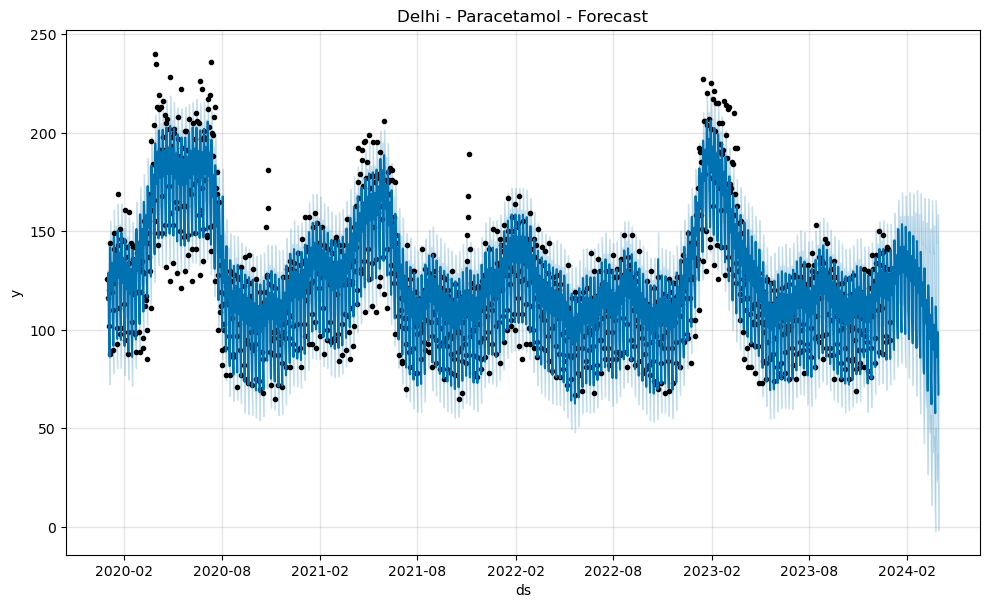

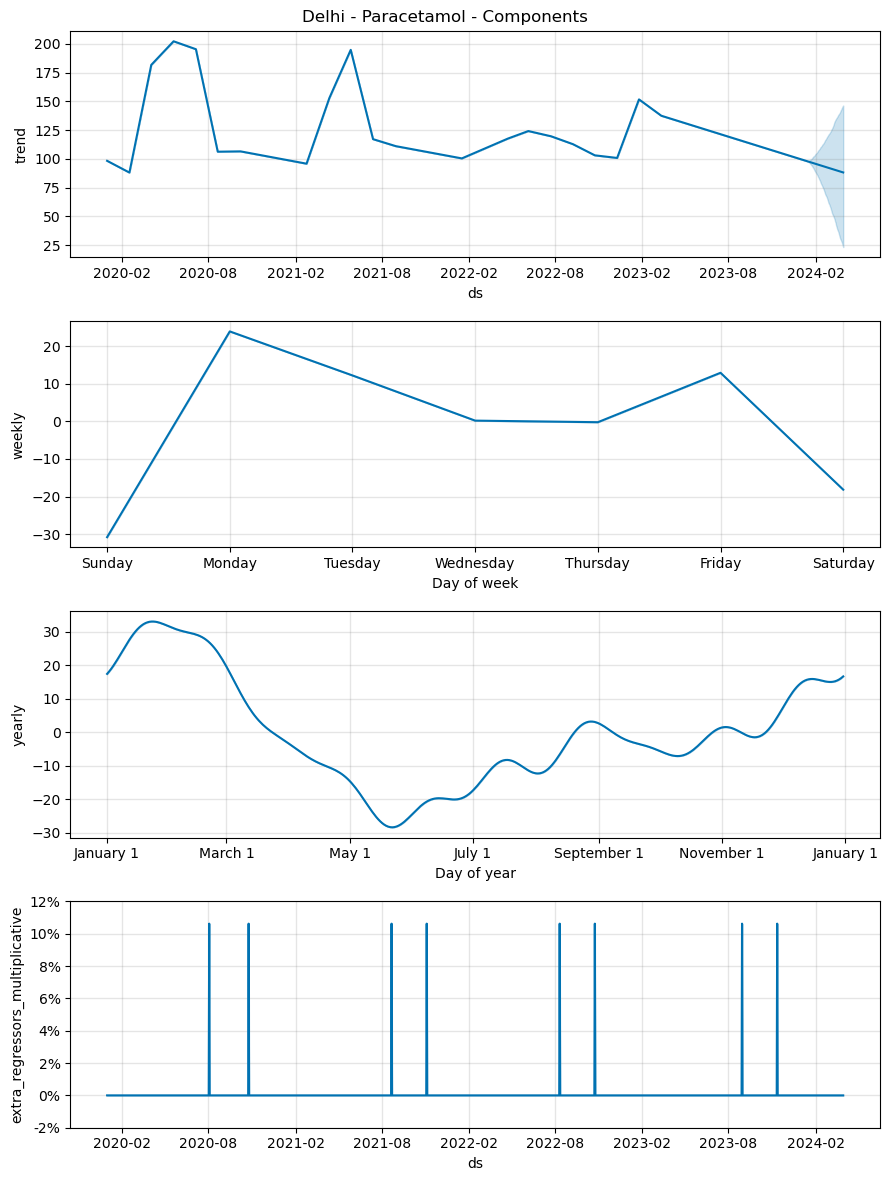

05:21:26 - cmdstanpy - INFO - Chain [1] start processing
05:21:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Training model for paracetamol in kolkata

Tuning hyperparameters...


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:27 - cmdstanpy - INFO - Chain [1] start processing
05:21:27 - cmdstanpy - INFO - Chain [1] done processing
05:21:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:27 - cmdstanpy - INFO - Chain [1] start processing
05:21:27 - cmdstanpy - INFO - Chain [1] done processing
05:21:27 - cmdstanpy - INFO - Chain [1] start processing
05:21:27 - cmdstanpy - INFO - Chain [1] done processing
05:21:27 - cmdstanpy - INFO - Chain [1] start processing
05:21:27 - cmdstanpy - INFO - Chain [1] done processing
05:21:27 - cmdstanpy - INFO - Chain [1] start processing
05:21:27 - cmdstanpy - INFO - Chain [1] done processing
05:21:28 - cmdstanpy - INFO - Chain [1] start processing
05:21:28 - cmdstanpy - INFO - Chain [1] done processing
05:21:28 - cmdstanpy - INFO - Chain [1] start processing
05:21:28 - cmdstanpy - INFO - Chain [1] done processing
05:21:28 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 44.16
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:29 - cmdstanpy - INFO - Chain [1] start processing
05:21:29 - cmdstanpy - INFO - Chain [1] done processing
05:21:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:29 - cmdstanpy - INFO - Chain [1] start processing
05:21:29 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start processing
05:21:30 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start processing
05:21:30 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start processing
05:21:30 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start processing
05:21:30 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start processing
05:21:30 - cmdstanpy - INFO - Chain [1] done processing
05:21:30 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 34.71
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:31 - cmdstanpy - INFO - Chain [1] start processing
05:21:31 - cmdstanpy - INFO - Chain [1] done processing
05:21:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:31 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
05:21:32 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
05:21:32 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
05:21:32 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
05:21:32 - cmdstanpy - INFO - Chain [1] start processing
05:21:32 - cmdstanpy - INFO - Chain [1] done processing
05:21:33 - cmdstanpy - INFO - Chain [1] start processing
05:21:33 - cmdstanpy - INFO - Chain [1] done processing
05:21:33 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.33
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:34 - cmdstanpy - INFO - Chain [1] start processing
05:21:34 - cmdstanpy - INFO - Chain [1] done processing
05:21:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:34 - cmdstanpy - INFO - Chain [1] start processing
05:21:34 - cmdstanpy - INFO - Chain [1] done processing
05:21:34 - cmdstanpy - INFO - Chain [1] start processing
05:21:34 - cmdstanpy - INFO - Chain [1] done processing
05:21:34 - cmdstanpy - INFO - Chain [1] start processing
05:21:34 - cmdstanpy - INFO - Chain [1] done processing
05:21:35 - cmdstanpy - INFO - Chain [1] start processing
05:21:35 - cmdstanpy - INFO - Chain [1] done processing
05:21:35 - cmdstanpy - INFO - Chain [1] start processing
05:21:35 - cmdstanpy - INFO - Chain [1] done processing
05:21:35 - cmdstanpy - INFO - Chain [1] start processing
05:21:35 - cmdstanpy - INFO - Chain [1] done processing
05:21:35 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 38.75
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:36 - cmdstanpy - INFO - Chain [1] start processing
05:21:36 - cmdstanpy - INFO - Chain [1] done processing
05:21:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:36 - cmdstanpy - INFO - Chain [1] start processing
05:21:36 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start processing
05:21:37 - cmdstanpy - INFO - Chain [1] done processing
05:21:37 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.15
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:38 - cmdstanpy - INFO - Chain [1] start processing
05:21:38 - cmdstanpy - INFO - Chain [1] done processing
05:21:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:38 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:39 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:39 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:39 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:39 - cmdstanpy - INFO - Chain [1] start processing
05:21:39 - cmdstanpy - INFO - Chain [1] done processing
05:21:40 - cmdstanpy - INFO - Chain [1] start processing
05:21:40 - cmdstanpy - INFO - Chain [1] done processing
05:21:40 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 37.92
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:41 - cmdstanpy - INFO - Chain [1] start processing
05:21:41 - cmdstanpy - INFO - Chain [1] done processing
05:21:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:41 - cmdstanpy - INFO - Chain [1] start processing
05:21:41 - cmdstanpy - INFO - Chain [1] done processing
05:21:41 - cmdstanpy - INFO - Chain [1] start processing
05:21:41 - cmdstanpy - INFO - Chain [1] done processing
05:21:41 - cmdstanpy - INFO - Chain [1] start processing
05:21:41 - cmdstanpy - INFO - Chain [1] done processing
05:21:42 - cmdstanpy - INFO - Chain [1] start processing
05:21:42 - cmdstanpy - INFO - Chain [1] done processing
05:21:42 - cmdstanpy - INFO - Chain [1] start processing
05:21:42 - cmdstanpy - INFO - Chain [1] done processing
05:21:42 - cmdstanpy - INFO - Chain [1] start processing
05:21:42 - cmdstanpy - INFO - Chain [1] done processing
05:21:42 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 36.82
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:43 - cmdstanpy - INFO - Chain [1] start processing
05:21:43 - cmdstanpy - INFO - Chain [1] done processing
05:21:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
05:21:43 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start processing
05:21:44 - cmdstanpy - INFO - Chain [1] done processing
05:21:44 - cmdstanpy - INFO - Chain [1] start process

Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.07
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:46 - cmdstanpy - INFO - Chain [1] done processing
05:21:46 - cmdstanpy - INFO - Chain [1] start processing
05:21:47 - cmdstanpy - INFO - Chain [1] done processing
05:21:47 - cmdstanpy - INFO - Chain [1] start processing
05:21:47 - cmdstanpy - INFO - Chain [1] done processing
05:21:47 - cmdstanpy - INFO - Chain [1] start processing
05:21:47 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.94
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing
05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing
05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing
05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing
05:21:48 - cmdstanpy - INFO - Chain [1] start processing
05:21:48 - cmdstanpy - INFO - Chain [1] done processing
05:21:49 - cmdstanpy - INFO - Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1] done processing
05:21:49 - cmdstanpy - INFO - Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1] done processing
05:21:49 - cmdstanpy - INFO - Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1] done processing
05:21:49 - cmdstanpy - INFO - Chain [1] start processing
05:21:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 39.77
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:50 - cmdstanpy - INFO - Chain [1] start processing
05:21:50 - cmdstanpy - INFO - Chain [1] done processing
05:21:50 - cmdstanpy - INFO - Chain [1] start processing
05:21:50 - cmdstanpy - INFO - Chain [1] done processing
05:21:50 - cmdstanpy - INFO - Chain [1] start processing
05:21:50 - cmdstanpy - INFO - Chain [1] done processing
05:21:50 - cmdstanpy - INFO - Chain [1] start processing
05:21:50 - cmdstanpy - INFO - Chain [1] done processing
05:21:51 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1] done processing
05:21:51 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1] done processing
05:21:51 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1] done processing
05:21:51 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1] done processing
05:21:51 - cmdstanpy - INFO - Chain [1] start processing
05:21:51 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.48
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:52 - cmdstanpy - INFO - Chain [1] start processing
05:21:52 - cmdstanpy - INFO - Chain [1] done processing
05:21:52 - cmdstanpy - INFO - Chain [1] start processing
05:21:52 - cmdstanpy - INFO - Chain [1] done processing
05:21:52 - cmdstanpy - INFO - Chain [1] start processing
05:21:52 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1] done processing
05:21:53 - cmdstanpy - INFO - Chain [1] start processing
05:21:53 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.94
---


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:54 - cmdstanpy - INFO - Chain [1] start processing
05:21:54 - cmdstanpy - INFO - Chain [1] done processing
05:21:54 - cmdstanpy - INFO - Chain [1] start processing
05:21:54 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:55 - cmdstanpy - INFO - Chain [1] start processing
05:21:55 - cmdstanpy - INFO - Chain [1] done processing
05:21:56 - cmdstanpy - INFO - Chain [1] start processing
05:21:56 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 42.65
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:56 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:57 - cmdstanpy - INFO - Chain [1] start processing
05:21:57 - cmdstanpy - INFO - Chain [1] done processing
05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1] done processing
05:21:58 - cmdstanpy - INFO - Chain [1] start processing
05:21:58 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.66
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:21:59 - cmdstanpy - INFO - Chain [1] start processing
05:21:59 - cmdstanpy - INFO - Chain [1] done processing
05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing
05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1] done processing
05:22:00 - cmdstanpy - INFO - Chain [1] start processing
05:22:00 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 41.21
---


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
05:22:01 - cmdstanpy - INFO - Chain [1] start processing
05:22:01 - cmdstanpy - INFO - Chain [1] done processing
05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing
05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing
05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1] done processing
05:22:02 - cmdstanpy - INFO - Chain [1] start processing
05:22:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 43.88
---


05:22:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing
05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:03 - cmdstanpy - INFO - Chain [1] done processing
05:22:03 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:04 - cmdstanpy - INFO - Chain [1] start processing
05:22:04 - cmdstanpy - INFO - Chain [1] done processing
05:22:05 - cmdstanpy - INFO - Chain [1] start processing
05:22:05 - cmdstanpy - INFO - Chain [1] done processing
05:22:05 - cmdstanpy - INFO - Chain [1] start processing
05:22:05 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.71
---


05:22:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:06 - cmdstanpy - INFO - Chain [1] start processing
05:22:06 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:07 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:07 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:07 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:07 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:07 - cmdstanpy - INFO - Chain [1] done processing
05:22:07 - cmdstanpy - INFO - Chain [1] start processing
05:22:08 - cmdstanpy - INFO - Chain [1] done processing
05:22:08 - cmdstanpy - INFO - Chain [1] start processing
05:22:08 - cmdstanpy - INFO - Chain [1] done processing
05:22:08 - cmdstanpy - INFO - Chain [1] start processing
05:22:08 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.56
---


05:22:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:09 - cmdstanpy - INFO - Chain [1] start processing
05:22:09 - cmdstanpy - INFO - Chain [1] done processing
05:22:09 - cmdstanpy - INFO - Chain [1] start processing
05:22:09 - cmdstanpy - INFO - Chain [1] done processing
05:22:09 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:10 - cmdstanpy - INFO - Chain [1] start processing
05:22:10 - cmdstanpy - INFO - Chain [1] done processing
05:22:11 - cmdstanpy - INFO - Chain [1] start processing
05:22:11 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.51
---


05:22:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:12 - cmdstanpy - INFO - Chain [1] start processing
05:22:12 - cmdstanpy - INFO - Chain [1] done processing
05:22:12 - cmdstanpy - INFO - Chain [1] start processing
05:22:12 - cmdstanpy - INFO - Chain [1] done processing
05:22:12 - cmdstanpy - INFO - Chain [1] start processing
05:22:12 - cmdstanpy - INFO - Chain [1] done processing
05:22:12 - cmdstanpy - INFO - Chain [1] start processing
05:22:12 - cmdstanpy - INFO - Chain [1] done processing
05:22:13 - cmdstanpy - INFO - Chain [1] start processing
05:22:13 - cmdstanpy - INFO - Chain [1] done processing
05:22:13 - cmdstanpy - INFO - Chain [1] start processing
05:22:13 - cmdstanpy - INFO - Chain [1] done processing
05:22:13 - cmdstanpy - INFO - Chain [1] start processing
05:22:13 - cmdstanpy - INFO - Chain [1] done processing
05:22:13 - cmdstanpy - INFO - Chain [1] start processing
05:22:13 - cmdstanpy - INFO - Chain [1] done processing
05:22:13 - cmdstanpy - INFO - Chain [1] start processing
05:22:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.71
---


05:22:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:14 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:15 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:15 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:15 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:15 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:15 - cmdstanpy - INFO - Chain [1] start processing
05:22:15 - cmdstanpy - INFO - Chain [1] done processing
05:22:16 - cmdstanpy - INFO - Chain [1] start processing
05:22:16 - cmdstanpy - INFO - Chain [1] done processing
05:22:16 - cmdstanpy - INFO - Chain [1] start processing
05:22:16 - cmdstanpy - INFO - Chain [1] done processing
05:22:16 - cmdstanpy - INFO - Chain [1] start processing
05:22:16 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.33
---


05:22:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:17 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:18 - cmdstanpy - INFO - Chain [1] done processing
05:22:18 - cmdstanpy - INFO - Chain [1] start processing
05:22:19 - cmdstanpy - INFO - Chain [1] done processing
05:22:19 - cmdstanpy - INFO - Chain [1] start processing
05:22:19 - cmdstanpy - INFO - Chain [1] done processing
05:22:19 - cmdstanpy - INFO - Chain [1] start processing
05:22:19 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.37
---


05:22:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:20 - cmdstanpy - INFO - Chain [1] start processing
05:22:20 - cmdstanpy - INFO - Chain [1] done processing
05:22:20 - cmdstanpy - INFO - Chain [1] start processing
05:22:20 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:21 - cmdstanpy - INFO - Chain [1] done processing
05:22:21 - cmdstanpy - INFO - Chain [1] start processing
05:22:22 - cmdstanpy - INFO - Chain [1] done processing
05:22:22 - cmdstanpy - INFO - Chain [1] start processing
05:22:22 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 50.65
---


05:22:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:23 - cmdstanpy - INFO - Chain [1] start processing
05:22:23 - cmdstanpy - INFO - Chain [1] done processing
05:22:23 - cmdstanpy - INFO - Chain [1] start processing
05:22:23 - cmdstanpy - INFO - Chain [1] done processing
05:22:23 - cmdstanpy - INFO - Chain [1] start processing
05:22:23 - cmdstanpy - INFO - Chain [1] done processing
05:22:24 - cmdstanpy - INFO - Chain [1] start processing
05:22:24 - cmdstanpy - INFO - Chain [1] done processing
05:22:24 - cmdstanpy - INFO - Chain [1] start processing
05:22:24 - cmdstanpy - INFO - Chain [1] done processing
05:22:24 - cmdstanpy - INFO - Chain [1] start processing
05:22:24 - cmdstanpy - INFO - Chain [1] done processing
05:22:24 - cmdstanpy - INFO - Chain [1] start processing
05:22:24 - cmdstanpy - INFO - Chain [1] done processing
05:22:24 - cmdstanpy - INFO - Chain [1] start processing
05:22:24 - cmdstanpy - INFO - Chain [1] done processing
05:22:25 - cmdstanpy - INFO - Chain [1] start processing
05:22:25 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.51
---


05:22:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:26 - cmdstanpy - INFO - Chain [1] start processing
05:22:26 - cmdstanpy - INFO - Chain [1] done processing
05:22:26 - cmdstanpy - INFO - Chain [1] start processing
05:22:26 - cmdstanpy - INFO - Chain [1] done processing
05:22:26 - cmdstanpy - INFO - Chain [1] start processing
05:22:27 - cmdstanpy - INFO - Chain [1] done processing
05:22:27 - cmdstanpy - INFO - Chain [1] start processing
05:22:27 - cmdstanpy - INFO - Chain [1] done processing
05:22:27 - cmdstanpy - INFO - Chain [1] start processing
05:22:27 - cmdstanpy - INFO - Chain [1] done processing
05:22:27 - cmdstanpy - INFO - Chain [1] start processing
05:22:27 - cmdstanpy - INFO - Chain [1] done processing
05:22:27 - cmdstanpy - INFO - Chain [1] start processing
05:22:28 - cmdstanpy - INFO - Chain [1] done processing
05:22:28 - cmdstanpy - INFO - Chain [1] start processing
05:22:28 - cmdstanpy - INFO - Chain [1] done processing
05:22:28 - cmdstanpy - INFO - Chain [1] start processing
05:22:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 57.57
---


05:22:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:30 - cmdstanpy - INFO - Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing
05:22:30 - cmdstanpy - INFO - Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing
05:22:30 - cmdstanpy - INFO - Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing
05:22:30 - cmdstanpy - INFO - Chain [1] start processing
05:22:30 - cmdstanpy - INFO - Chain [1] done processing
05:22:31 - cmdstanpy - INFO - Chain [1] start processing
05:22:31 - cmdstanpy - INFO - Chain [1] done processing
05:22:31 - cmdstanpy - INFO - Chain [1] start processing
05:22:31 - cmdstanpy - INFO - Chain [1] done processing
05:22:31 - cmdstanpy - INFO - Chain [1] start processing
05:22:31 - cmdstanpy - INFO - Chain [1] done processing
05:22:31 - cmdstanpy - INFO - Chain [1] start processing
05:22:31 - cmdstanpy - INFO - Chain [1] done processing
05:22:32 - cmdstanpy - INFO - Chain [1] start processing
05:22:32 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 50.49
---


05:22:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:33 - cmdstanpy - INFO - Chain [1] start processing
05:22:33 - cmdstanpy - INFO - Chain [1] done processing
05:22:33 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:34 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:34 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:34 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:34 - cmdstanpy - INFO - Chain [1] start processing
05:22:34 - cmdstanpy - INFO - Chain [1] done processing
05:22:35 - cmdstanpy - INFO - Chain [1] start processing
05:22:35 - cmdstanpy - INFO - Chain [1] done processing
05:22:35 - cmdstanpy - INFO - Chain [1] start processing
05:22:35 - cmdstanpy - INFO - Chain [1] done processing
05:22:35 - cmdstanpy - INFO - Chain [1] start processing
05:22:35 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 48.18
---


05:22:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:37 - cmdstanpy - INFO - Chain [1] start processing
05:22:37 - cmdstanpy - INFO - Chain [1] done processing
05:22:37 - cmdstanpy - INFO - Chain [1] start processing
05:22:37 - cmdstanpy - INFO - Chain [1] done processing
05:22:37 - cmdstanpy - INFO - Chain [1] start processing
05:22:37 - cmdstanpy - INFO - Chain [1] done processing
05:22:37 - cmdstanpy - INFO - Chain [1] start processing
05:22:37 - cmdstanpy - INFO - Chain [1] done processing
05:22:37 - cmdstanpy - INFO - Chain [1] start processing
05:22:37 - cmdstanpy - INFO - Chain [1] done processing
05:22:38 - cmdstanpy - INFO - Chain [1] start processing
05:22:38 - cmdstanpy - INFO - Chain [1] done processing
05:22:38 - cmdstanpy - INFO - Chain [1] start processing
05:22:38 - cmdstanpy - INFO - Chain [1] done processing
05:22:38 - cmdstanpy - INFO - Chain [1] start processing
05:22:38 - cmdstanpy - INFO - Chain [1] done processing
05:22:38 - cmdstanpy - INFO - Chain [1] start processing
05:22:39 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.53
---


05:22:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:40 - cmdstanpy - INFO - Chain [1] start processing
05:22:40 - cmdstanpy - INFO - Chain [1] done processing
05:22:40 - cmdstanpy - INFO - Chain [1] start processing
05:22:40 - cmdstanpy - INFO - Chain [1] done processing
05:22:40 - cmdstanpy - INFO - Chain [1] start processing
05:22:40 - cmdstanpy - INFO - Chain [1] done processing
05:22:41 - cmdstanpy - INFO - Chain [1] start processing
05:22:41 - cmdstanpy - INFO - Chain [1] done processing
05:22:41 - cmdstanpy - INFO - Chain [1] start processing
05:22:41 - cmdstanpy - INFO - Chain [1] done processing
05:22:41 - cmdstanpy - INFO - Chain [1] start processing
05:22:41 - cmdstanpy - INFO - Chain [1] done processing
05:22:41 - cmdstanpy - INFO - Chain [1] start processing
05:22:41 - cmdstanpy - INFO - Chain [1] done processing
05:22:42 - cmdstanpy - INFO - Chain [1] start processing
05:22:42 - cmdstanpy - INFO - Chain [1] done processing
05:22:42 - cmdstanpy - INFO - Chain [1] start processing
05:22:42 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.88
---


05:22:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:44 - cmdstanpy - INFO - Chain [1] start processing
05:22:44 - cmdstanpy - INFO - Chain [1] done processing
05:22:44 - cmdstanpy - INFO - Chain [1] start processing
05:22:44 - cmdstanpy - INFO - Chain [1] done processing
05:22:44 - cmdstanpy - INFO - Chain [1] start processing
05:22:44 - cmdstanpy - INFO - Chain [1] done processing
05:22:44 - cmdstanpy - INFO - Chain [1] start processing
05:22:44 - cmdstanpy - INFO - Chain [1] done processing
05:22:44 - cmdstanpy - INFO - Chain [1] start processing
05:22:44 - cmdstanpy - INFO - Chain [1] done processing
05:22:45 - cmdstanpy - INFO - Chain [1] start processing
05:22:45 - cmdstanpy - INFO - Chain [1] done processing
05:22:45 - cmdstanpy - INFO - Chain [1] start processing
05:22:45 - cmdstanpy - INFO - Chain [1] done processing
05:22:45 - cmdstanpy - INFO - Chain [1] start processing
05:22:45 - cmdstanpy - INFO - Chain [1] done processing
05:22:45 - cmdstanpy - INFO - Chain [1] start processing
05:22:45 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.14
---


05:22:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:47 - cmdstanpy - INFO - Chain [1] start processing
05:22:47 - cmdstanpy - INFO - Chain [1] done processing
05:22:47 - cmdstanpy - INFO - Chain [1] start processing
05:22:47 - cmdstanpy - INFO - Chain [1] done processing
05:22:47 - cmdstanpy - INFO - Chain [1] start processing
05:22:47 - cmdstanpy - INFO - Chain [1] done processing
05:22:47 - cmdstanpy - INFO - Chain [1] start processing
05:22:48 - cmdstanpy - INFO - Chain [1] done processing
05:22:48 - cmdstanpy - INFO - Chain [1] start processing
05:22:48 - cmdstanpy - INFO - Chain [1] done processing
05:22:48 - cmdstanpy - INFO - Chain [1] start processing
05:22:48 - cmdstanpy - INFO - Chain [1] done processing
05:22:48 - cmdstanpy - INFO - Chain [1] start processing
05:22:48 - cmdstanpy - INFO - Chain [1] done processing
05:22:48 - cmdstanpy - INFO - Chain [1] start processing
05:22:49 - cmdstanpy - INFO - Chain [1] done processing
05:22:49 - cmdstanpy - INFO - Chain [1] start processing
05:22:49 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 47.60
---


05:22:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:50 - cmdstanpy - INFO - Chain [1] start processing
05:22:50 - cmdstanpy - INFO - Chain [1] done processing
05:22:50 - cmdstanpy - INFO - Chain [1] start processing
05:22:50 - cmdstanpy - INFO - Chain [1] done processing
05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing
05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing
05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing
05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing
05:22:51 - cmdstanpy - INFO - Chain [1] start processing
05:22:51 - cmdstanpy - INFO - Chain [1] done processing
05:22:52 - cmdstanpy - INFO - Chain [1] start processing
05:22:52 - cmdstanpy - INFO - Chain [1] done processing
05:22:52 - cmdstanpy - INFO - Chain [1] start processing
05:22:52 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.04
---


05:22:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:54 - cmdstanpy - INFO - Chain [1] start processing
05:22:54 - cmdstanpy - INFO - Chain [1] done processing
05:22:54 - cmdstanpy - INFO - Chain [1] start processing
05:22:54 - cmdstanpy - INFO - Chain [1] done processing
05:22:54 - cmdstanpy - INFO - Chain [1] start processing
05:22:55 - cmdstanpy - INFO - Chain [1] done processing
05:22:55 - cmdstanpy - INFO - Chain [1] start processing
05:22:55 - cmdstanpy - INFO - Chain [1] done processing
05:22:55 - cmdstanpy - INFO - Chain [1] start processing
05:22:55 - cmdstanpy - INFO - Chain [1] done processing
05:22:55 - cmdstanpy - INFO - Chain [1] start processing
05:22:56 - cmdstanpy - INFO - Chain [1] done processing
05:22:56 - cmdstanpy - INFO - Chain [1] start processing
05:22:56 - cmdstanpy - INFO - Chain [1] done processing
05:22:56 - cmdstanpy - INFO - Chain [1] start processing
05:22:57 - cmdstanpy - INFO - Chain [1] done processing
05:22:57 - cmdstanpy - INFO - Chain [1] start processing
05:22:57 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 62.65
---


05:22:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:22:59 - cmdstanpy - INFO - Chain [1] start processing
05:23:00 - cmdstanpy - INFO - Chain [1] done processing
05:23:00 - cmdstanpy - INFO - Chain [1] start processing
05:23:00 - cmdstanpy - INFO - Chain [1] done processing
05:23:00 - cmdstanpy - INFO - Chain [1] start processing
05:23:00 - cmdstanpy - INFO - Chain [1] done processing
05:23:00 - cmdstanpy - INFO - Chain [1] start processing
05:23:00 - cmdstanpy - INFO - Chain [1] done processing
05:23:00 - cmdstanpy - INFO - Chain [1] start processing
05:23:01 - cmdstanpy - INFO - Chain [1] done processing
05:23:01 - cmdstanpy - INFO - Chain [1] start processing
05:23:01 - cmdstanpy - INFO - Chain [1] done processing
05:23:01 - cmdstanpy - INFO - Chain [1] start processing
05:23:01 - cmdstanpy - INFO - Chain [1] done processing
05:23:01 - cmdstanpy - INFO - Chain [1] start processing
05:23:02 - cmdstanpy - INFO - Chain [1] done processing
05:23:02 - cmdstanpy - INFO - Chain [1] start processing
05:23:02 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 52.11
---


05:23:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:04 - cmdstanpy - INFO - Chain [1] start processing
05:23:05 - cmdstanpy - INFO - Chain [1] done processing
05:23:05 - cmdstanpy - INFO - Chain [1] start processing
05:23:05 - cmdstanpy - INFO - Chain [1] done processing
05:23:05 - cmdstanpy - INFO - Chain [1] start processing
05:23:05 - cmdstanpy - INFO - Chain [1] done processing
05:23:05 - cmdstanpy - INFO - Chain [1] start processing
05:23:05 - cmdstanpy - INFO - Chain [1] done processing
05:23:05 - cmdstanpy - INFO - Chain [1] start processing
05:23:06 - cmdstanpy - INFO - Chain [1] done processing
05:23:06 - cmdstanpy - INFO - Chain [1] start processing
05:23:06 - cmdstanpy - INFO - Chain [1] done processing
05:23:06 - cmdstanpy - INFO - Chain [1] start processing
05:23:06 - cmdstanpy - INFO - Chain [1] done processing
05:23:07 - cmdstanpy - INFO - Chain [1] start processing
05:23:07 - cmdstanpy - INFO - Chain [1] done processing
05:23:07 - cmdstanpy - INFO - Chain [1] start processing
05:23:07 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.13
---


05:23:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:10 - cmdstanpy - INFO - Chain [1] start processing
05:23:10 - cmdstanpy - INFO - Chain [1] done processing
05:23:10 - cmdstanpy - INFO - Chain [1] start processing
05:23:10 - cmdstanpy - INFO - Chain [1] done processing
05:23:10 - cmdstanpy - INFO - Chain [1] start processing
05:23:10 - cmdstanpy - INFO - Chain [1] done processing
05:23:10 - cmdstanpy - INFO - Chain [1] start processing
05:23:10 - cmdstanpy - INFO - Chain [1] done processing
05:23:11 - cmdstanpy - INFO - Chain [1] start processing
05:23:11 - cmdstanpy - INFO - Chain [1] done processing
05:23:11 - cmdstanpy - INFO - Chain [1] start processing
05:23:11 - cmdstanpy - INFO - Chain [1] done processing
05:23:11 - cmdstanpy - INFO - Chain [1] start processing
05:23:12 - cmdstanpy - INFO - Chain [1] done processing
05:23:12 - cmdstanpy - INFO - Chain [1] start processing
05:23:12 - cmdstanpy - INFO - Chain [1] done processing
05:23:12 - cmdstanpy - INFO - Chain [1] start processing
05:23:13 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 49.98
---


05:23:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:15 - cmdstanpy - INFO - Chain [1] start processing
05:23:15 - cmdstanpy - INFO - Chain [1] done processing
05:23:16 - cmdstanpy - INFO - Chain [1] start processing
05:23:16 - cmdstanpy - INFO - Chain [1] done processing
05:23:16 - cmdstanpy - INFO - Chain [1] start processing
05:23:16 - cmdstanpy - INFO - Chain [1] done processing
05:23:16 - cmdstanpy - INFO - Chain [1] start processing
05:23:16 - cmdstanpy - INFO - Chain [1] done processing
05:23:16 - cmdstanpy - INFO - Chain [1] start processing
05:23:17 - cmdstanpy - INFO - Chain [1] done processing
05:23:17 - cmdstanpy - INFO - Chain [1] start processing
05:23:17 - cmdstanpy - INFO - Chain [1] done processing
05:23:17 - cmdstanpy - INFO - Chain [1] start processing
05:23:17 - cmdstanpy - INFO - Chain [1] done processing
05:23:18 - cmdstanpy - INFO - Chain [1] start processing
05:23:18 - cmdstanpy - INFO - Chain [1] done processing
05:23:18 - cmdstanpy - INFO - Chain [1] start processing
05:23:18 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.15
---


05:23:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing
05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing
05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing
05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing
05:23:21 - cmdstanpy - INFO - Chain [1] start processing
05:23:21 - cmdstanpy - INFO - Chain [1] done processing
05:23:22 - cmdstanpy - INFO - Chain [1] start processing
05:23:22 - cmdstanpy - INFO - Chain [1] done processing
05:23:22 - cmdstanpy - INFO - Chain [1] start processing
05:23:22 - cmdstanpy - INFO - Chain [1] done processing
05:23:22 - cmdstanpy - INFO - Chain [1] start processing
05:23:23 - cmdstanpy - INFO - Chain [1] done processing
05:23:23 - cmdstanpy - INFO - Chain [1] start processing
05:23:23 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.84
---


05:23:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:26 - cmdstanpy - INFO - Chain [1] start processing
05:23:26 - cmdstanpy - INFO - Chain [1] done processing
05:23:26 - cmdstanpy - INFO - Chain [1] start processing
05:23:26 - cmdstanpy - INFO - Chain [1] done processing
05:23:26 - cmdstanpy - INFO - Chain [1] start processing
05:23:26 - cmdstanpy - INFO - Chain [1] done processing
05:23:26 - cmdstanpy - INFO - Chain [1] start processing
05:23:26 - cmdstanpy - INFO - Chain [1] done processing
05:23:26 - cmdstanpy - INFO - Chain [1] start processing
05:23:27 - cmdstanpy - INFO - Chain [1] done processing
05:23:27 - cmdstanpy - INFO - Chain [1] start processing
05:23:27 - cmdstanpy - INFO - Chain [1] done processing
05:23:27 - cmdstanpy - INFO - Chain [1] start processing
05:23:27 - cmdstanpy - INFO - Chain [1] done processing
05:23:28 - cmdstanpy - INFO - Chain [1] start processing
05:23:28 - cmdstanpy - INFO - Chain [1] done processing
05:23:28 - cmdstanpy - INFO - Chain [1] start processing
05:23:28 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 46.21
---


05:23:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

05:23:31 - cmdstanpy - INFO - Chain [1] start processing
05:23:31 - cmdstanpy - INFO - Chain [1] done processing
05:23:31 - cmdstanpy - INFO - Chain [1] start processing
05:23:31 - cmdstanpy - INFO - Chain [1] done processing
05:23:31 - cmdstanpy - INFO - Chain [1] start processing
05:23:31 - cmdstanpy - INFO - Chain [1] done processing
05:23:31 - cmdstanpy - INFO - Chain [1] start processing
05:23:31 - cmdstanpy - INFO - Chain [1] done processing
05:23:32 - cmdstanpy - INFO - Chain [1] start processing
05:23:32 - cmdstanpy - INFO - Chain [1] done processing
05:23:32 - cmdstanpy - INFO - Chain [1] start processing
05:23:32 - cmdstanpy - INFO - Chain [1] done processing
05:23:32 - cmdstanpy - INFO - Chain [1] start processing
05:23:33 - cmdstanpy - INFO - Chain [1] done processing
05:23:33 - cmdstanpy - INFO - Chain [1] start processing
05:23:33 - cmdstanpy - INFO - Chain [1] done processing
05:23:33 - cmdstanpy - INFO - Chain [1] start processing
05:23:34 - cmdstanpy - INFO - Chain [1]

Parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
RMSE: 51.94
---

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False}
Best RMSE: 34.71

Training final model...


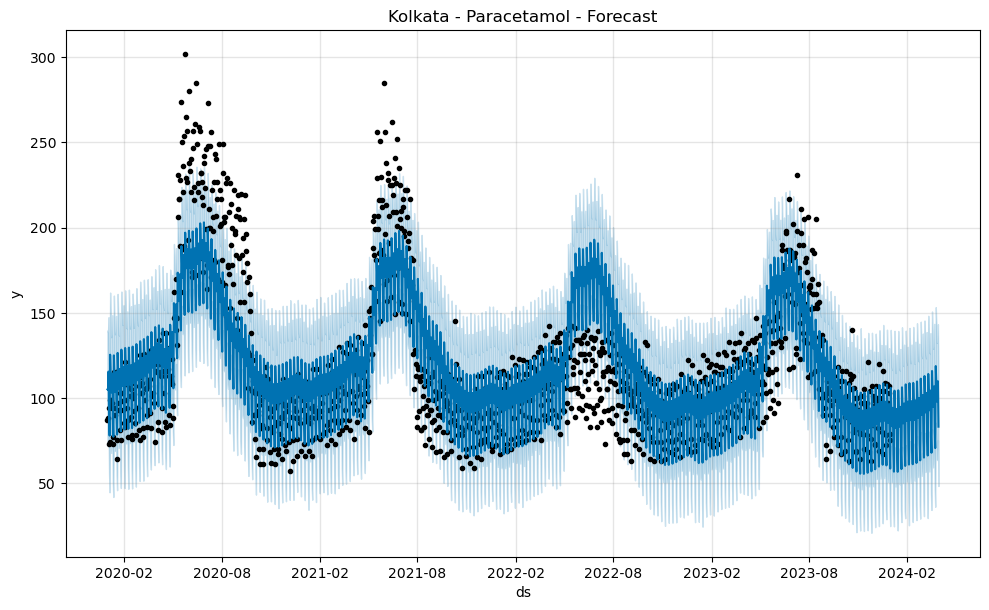

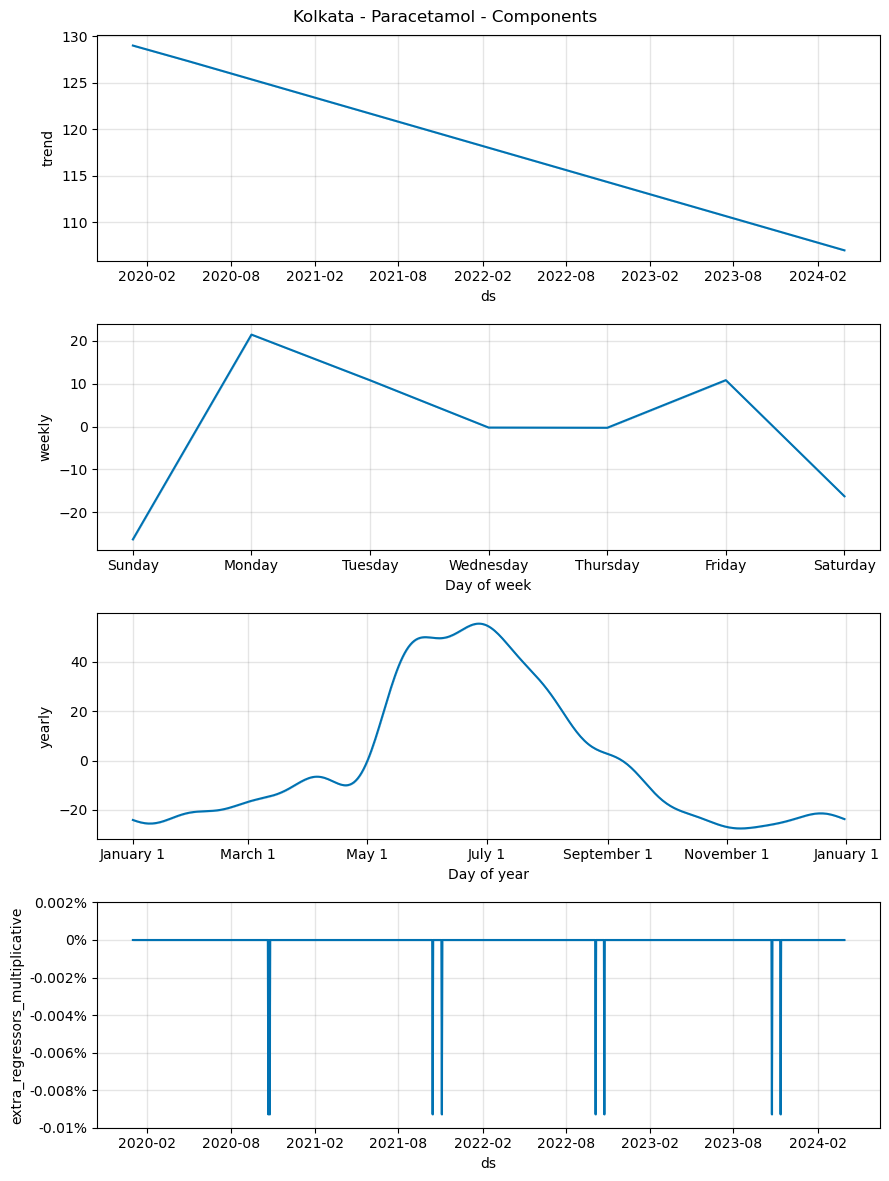

In [22]:
# Cell 8: Train Paracetamol Models
# Train for Delhi
delhi_paracetamol = train_single_medicine('delhi', 'paracetamol')

# Train for Kolkata
kolkata_paracetamol = train_single_medicine('kolkata', 'paracetamol')

In [23]:
# Cell 9: Save Models and Results
def save_model_results(results: dict, region: str, medicine: str):
    """Save model, forecast, and metrics"""
    # Create directories if they don't exist
    Path('models').mkdir(exist_ok=True)
    Path('forecasts').mkdir(exist_ok=True)
    Path('metrics').mkdir(exist_ok=True)
    
    # Save model
    joblib.dump(results['model'], f'models/{region}_{medicine}_model.pkl')
    
    # Save forecast
    results['forecast'].to_csv(f'forecasts/{region}_{medicine}_forecast.csv')
    
    # Save metrics
    with open(f'metrics/{region}_{medicine}_metrics.json', 'w') as f:
        json.dump(results['metrics'], f)

# Save Paracetamol results
save_model_results(delhi_paracetamol, 'delhi', 'paracetamol')
save_model_results(kolkata_paracetamol, 'kolkata', 'paracetamol')

In [24]:
# Cell 10: Prepare API Format
def prepare_api_forecast(forecast: pd.DataFrame, medicine_id: int, region: str) -> list:
    """Format forecast for API consumption"""
    # Get quarterly predictions
    quarterly_data = []
    
    for quarter in range(1, 5):
        quarter_start = forecast['ds'].max() + pd.DateOffset(months=3*(quarter-1))
        quarter_end = forecast['ds'].max() + pd.DateOffset(months=3*quarter)
        
        mask = (forecast['ds'] > quarter_start) & (forecast['ds'] <= quarter_end)
        quarter_forecast = forecast[mask]
        
        if not quarter_forecast.empty:
            period = f"{quarter_start.year}-Q{(quarter_start.month-1)//3 + 1}"
            predicted_demand = int(quarter_forecast['yhat'].sum())
            
            quarterly_data.append({
                'medicine_id': medicine_id,
                'region': region,
                'period': period,
                'predicted_demand': predicted_demand,
                'created_at': datetime.now().strftime('%Y-%m-%d')
            })
    
    return quarterly_data

# Prepare API forecasts for Paracetamol
delhi_api_forecast = prepare_api_forecast(delhi_paracetamol['forecast'], 1, 'delhi')
kolkata_api_forecast = prepare_api_forecast(kolkata_paracetamol['forecast'], 1, 'kolkata')

# Create api directory if it doesn't exist
api_dir = Path('api')
api_dir.mkdir(exist_ok=True)

# Save combined API forecasts
api_forecasts = delhi_api_forecast + kolkata_api_forecast

# Debug print to verify data
print("Number of forecasts:", len(api_forecasts))
print("Sample forecast:", api_forecasts[0] if api_forecasts else "No forecasts")

# Save to CSV with explicit column names
df = pd.DataFrame(api_forecasts)
if not df.empty:
    df.to_csv(api_dir / 'predictions.csv', index=False, columns=['medicine_id', 'region', 'period', 'predicted_demand', 'created_at'])
else:
    print("Warning: No forecast data to save!")

Number of forecasts: 0
Sample forecast: No forecasts
